In [113]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("wenruliu/adult-income-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/adult-income-dataset


In [114]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from scipy.optimize import differential_evolution
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Data Preparation
---

In [115]:
data_name = os.listdir(path)[0]

full_path = os.path.join(path,data_name)

df = pd.read_csv(full_path)

In [116]:
df.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [117]:
df.columns = df.columns.str.strip()
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [118]:
print("No. of Rows:",df.shape[0])
print("No. of Columns:", df.shape[1])

No. of Rows: 48842
No. of Columns: 15


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [120]:
df.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [121]:
df.isnull().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,0
relationship,0
race,0
gender,0


In [122]:
df.isin(["?"]).sum()

,0
age,0
workclass,2799
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,2809
relationship,0
race,0
gender,0


In [123]:
df["workclass"] = df["workclass"].replace("?", np.nan)
df["occupation"] = df["occupation"].replace("?", np.nan)
df["native-country"] = df["native-country"].replace("?", np.nan)

In [124]:
df.dropna(subset=["native-country"],inplace=True,ignore_index=True)

df.fillna({"workclass":"Unknown"},inplace=True)

df.loc[df["workclass"]=="Never-worked","occupation"]="No-job"
df.loc[df["workclass"]=="Unknown","occupation"]="Unknown-job"

In [125]:
df.isnull().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,0
relationship,0
race,0
gender,0


In [126]:
per_missing=df.isnull().sum()*100/len(df)
per_missing

,0
age,0.0
workclass,0.0
fnlwgt,0.0
education,0.0
educational-num,0.0
marital-status,0.0
occupation,0.0
relationship,0.0
race,0.0
gender,0.0


In [127]:
df.duplicated().sum()

np.int64(51)

In [128]:
df = df.drop_duplicates()

In [129]:
def clean_education(x):
    if x=="Bachelors":
        return "Bachelor's Degree"
    if x=="Assoc-voc":
        return "Bachelor's Degree"
    if x=="Masters":
        return "Master's Degree"
    if x=="Prof-school":
         return "Master's Degree"
    if x=="Doctorate":
        return "Doctorate Degree"
    else:
        return "Less than Bachelor's"

In [130]:
df["education"]=df["education"].apply(clean_education)

<ipython-input-130-391cf17919c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["education"]=df["education"].apply(clean_education)


In [131]:
df["education"].unique()

array(["Less than Bachelor's", "Master's Degree", "Bachelor's Degree",
       'Doctorate Degree'], dtype=object)

<ipython-input-132-3727dae5fe96>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="workclass", order=work_values.index, ax=ax, palette="Set2")


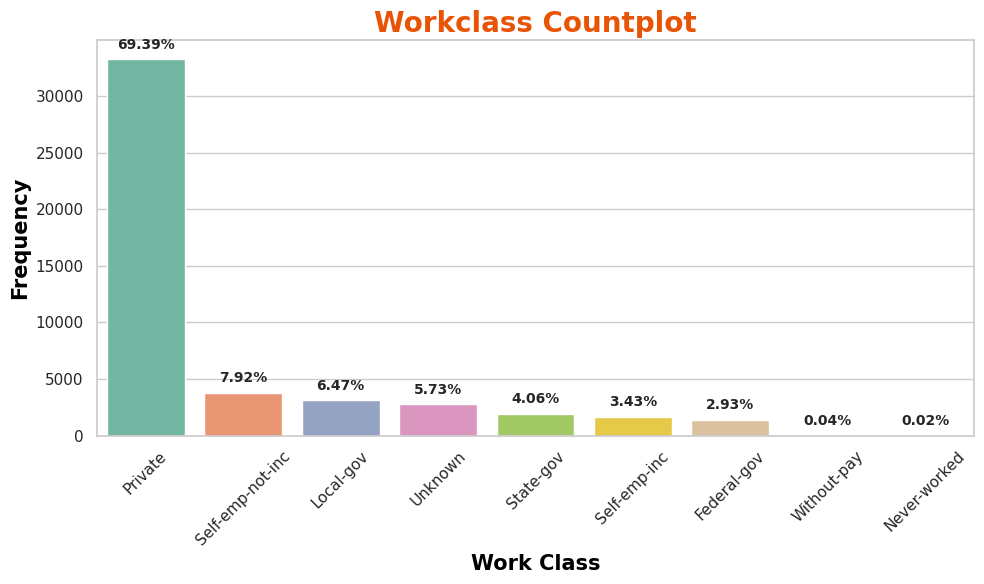

In [132]:
work_values = df["workclass"].value_counts()
work_percentages = (work_values / len(df) * 100).round(2)

fig, ax = plt.subplots(figsize=(10, 6))
sns.set(style="whitegrid")

sns.countplot(data=df, x="workclass", order=work_values.index, ax=ax, palette="Set2")
ax.set_title("Workclass Countplot", fontsize=20, weight='bold', color='#e85304')
ax.set_xlabel("Work Class", fontsize=15, weight='bold', color='black')
ax.set_ylabel("Frequency", fontsize=15, weight='bold', color='black')
ax.tick_params(axis='x', labelrotation=45)

for idx, (value, pct) in enumerate(zip(work_values, work_percentages)):
    ax.text(idx, value + max(work_values)*0.02, f"{pct}%",
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

<ipython-input-133-89a9632889a5>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="education", order=education_values.index, ax=ax, palette="Set2")


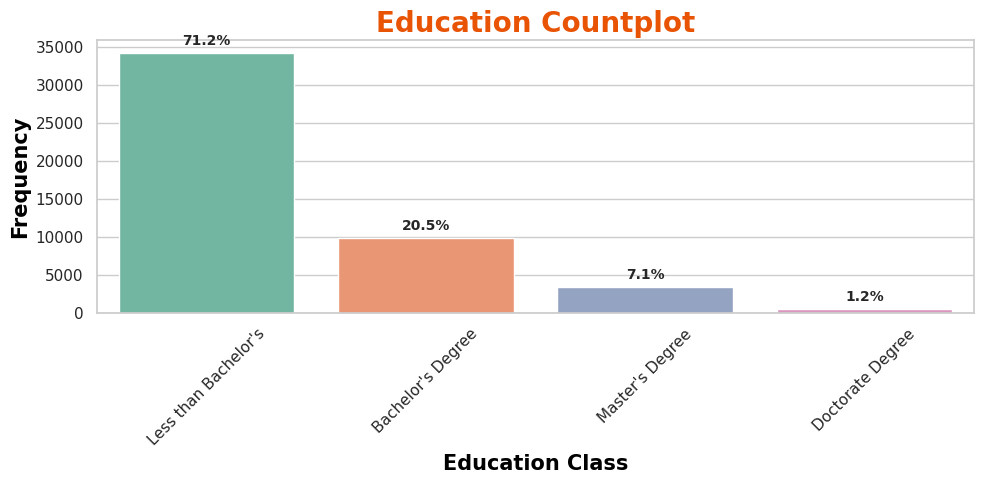

In [133]:
education_values = df["education"].value_counts()
education_percentages = (education_values / len(df) * 100).round(1)

fig, ax = plt.subplots(figsize=(10, 5))
sns.set(style="whitegrid")

sns.countplot(data=df, x="education", order=education_values.index, ax=ax, palette="Set2")
ax.set_title("Education Countplot", fontsize=20, weight='bold', color='#e85304')
ax.set_xlabel("Education Class", fontsize=15, weight='bold', color='black')
ax.set_ylabel("Frequency", fontsize=15, weight='bold', color='black')
ax.tick_params(axis='x', labelrotation=45)

for idx, (value, pct) in enumerate(zip(education_values, education_percentages)):
    ax.text(idx, value + max(education_values)*0.02, f"{pct}%",
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

<ipython-input-134-c9c2702acbaf>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="marital-status", order=marital_values.index, ax=ax, palette="Set2")


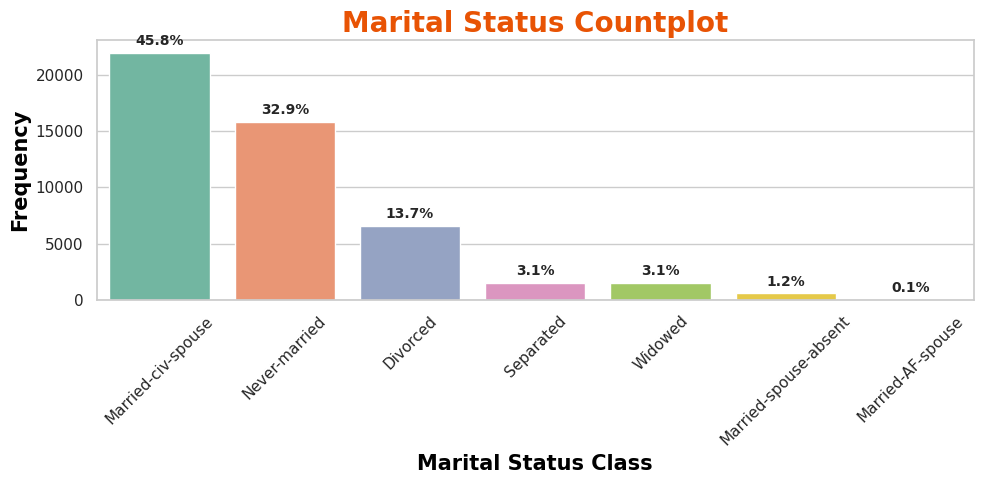

In [134]:
marital_values = df["marital-status"].value_counts()
marital_percentages = (marital_values / len(df) * 100).round(1)

fig, ax = plt.subplots(figsize=(10, 5))
sns.set(style="whitegrid")

sns.countplot(data=df, x="marital-status", order=marital_values.index, ax=ax, palette="Set2")
ax.set_title("Marital Status Countplot", fontsize=20, weight='bold', color='#e85304')
ax.set_xlabel("Marital Status Class", fontsize=15, weight='bold', color='black')
ax.set_ylabel("Frequency", fontsize=15, weight='bold', color='black')
ax.tick_params(axis='x', labelrotation=45)

for idx, (value, pct) in enumerate(zip(marital_values, marital_percentages)):
    ax.text(idx, value + max(marital_values)*0.02, f"{pct}%",
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

<ipython-input-135-ba06805cbafd>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="occupation", order=occu_values.index, ax=ax, palette="Set2")


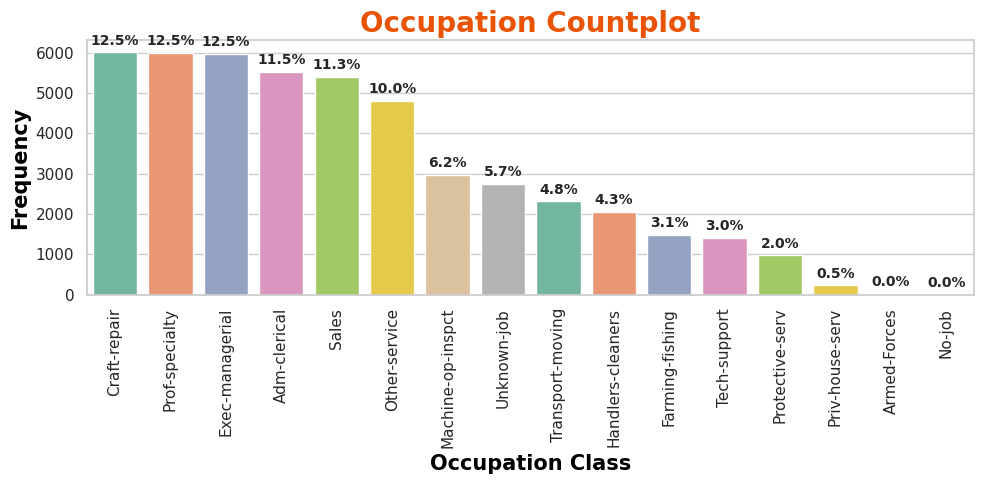

In [135]:
occu_values = df["occupation"].value_counts()
occu_percentages = (occu_values / len(df) * 100).round(1)

fig, ax = plt.subplots(figsize=(10, 5))
sns.set(style="whitegrid")

sns.countplot(data=df, x="occupation", order=occu_values.index, ax=ax, palette="Set2")
ax.set_title("Occupation Countplot", fontsize=20, weight='bold', color='#e85304')
ax.set_xlabel("Occupation Class", fontsize=15, weight='bold', color='black')
ax.set_ylabel("Frequency", fontsize=15, weight='bold', color='black')
ax.tick_params(axis='x', labelrotation=90)

for idx, (value, pct) in enumerate(zip(occu_values, occu_percentages)):
    ax.text(idx, value + max(occu_values)*0.02, f"{pct}%",
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

<ipython-input-136-601f0a2900d7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="relationship", order=relation_values.index, ax=ax, palette="Set2")


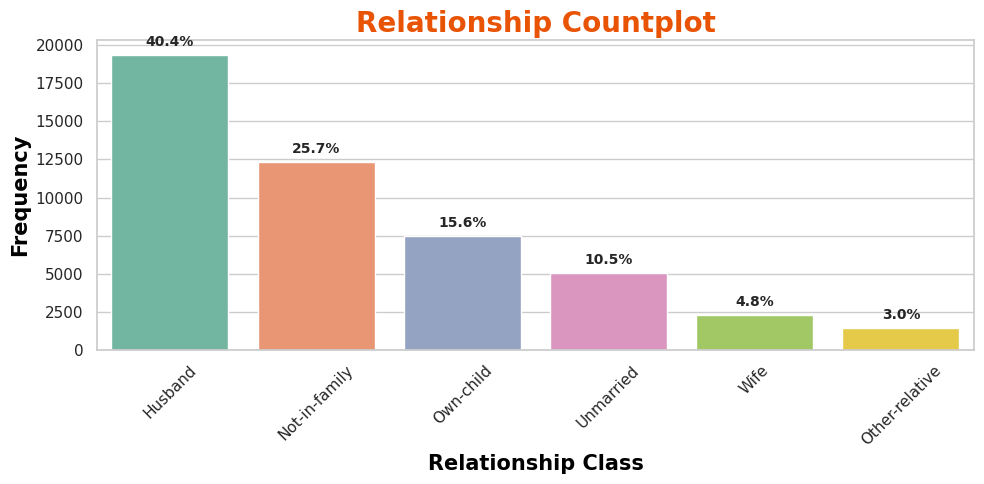

In [136]:
relation_values = df["relationship"].value_counts()
relation_percentages = (relation_values / len(df) * 100).round(1)

fig, ax = plt.subplots(figsize=(10, 5))
sns.set(style="whitegrid")

sns.countplot(data=df, x="relationship", order=relation_values.index, ax=ax, palette="Set2")
ax.set_title("Relationship Countplot", fontsize=20, weight='bold', color='#e85304')
ax.set_xlabel("Relationship Class", fontsize=15, weight='bold', color='black')
ax.set_ylabel("Frequency", fontsize=15, weight='bold', color='black')
ax.tick_params(axis='x', labelrotation=45)

for idx, (value, pct) in enumerate(zip(relation_values, relation_percentages)):
    ax.text(idx, value + max(relation_values)*0.02, f"{pct}%",
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

<ipython-input-137-504effd27de0>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="gender", order=gender_values.index, ax=axis[0], palette=colors)


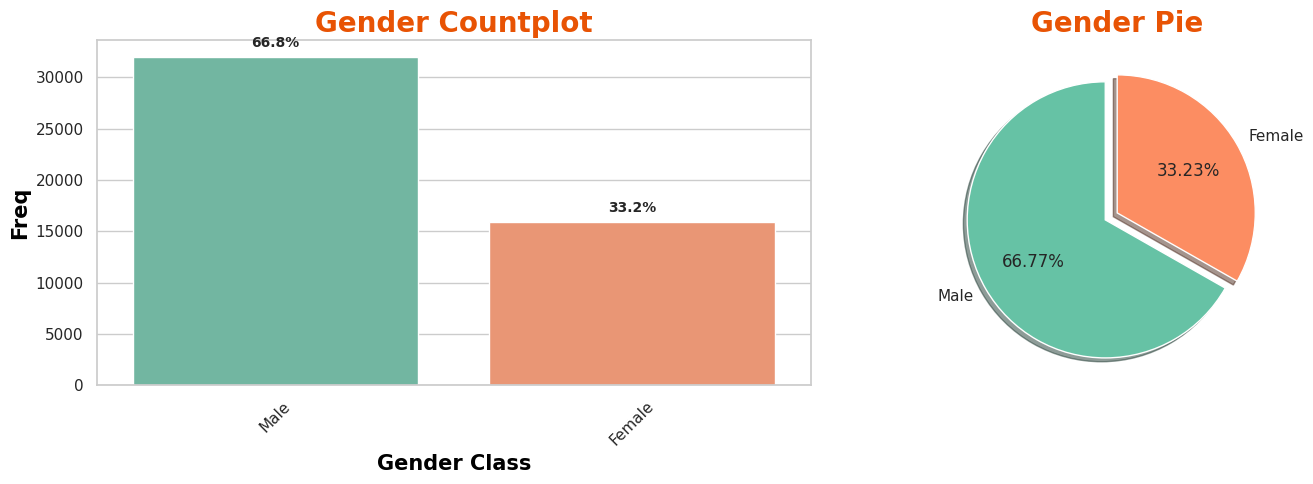

In [137]:
gender_values = df["gender"].value_counts()
gender_percentages = (gender_values / len(df) * 100).round(1)

palette = sns.color_palette("Set2")
colors = [palette[i] for i in range(len(gender_values))]

fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.set(style="whitegrid")

axis[0].set_title("Gender Countplot", fontsize=20, weight='bold', color='#e85304')
sns.countplot(data=df, x="gender", order=gender_values.index, ax=axis[0], palette=colors)
axis[0].set_xlabel("Gender Class", fontsize=15, weight="bold", color='black')
axis[0].set_ylabel("Freq", fontsize=15, weight="bold", color='black')
axis[0].tick_params(axis='x', labelrotation=45)

for idx, (value, pct) in enumerate(zip(gender_values, gender_percentages)):
    axis[0].text(idx, value + max(gender_values)*0.02, f"{pct}%",
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

axis[1].pie(gender_values.values, labels=gender_values.index, autopct="%.2f%%",
            explode=[0.1] + [0]*(len(gender_values)-1), shadow=True, startangle=90, colors=colors)
axis[1].set_title("Gender Pie", fontsize=20, color='#e85304', weight="bold")

plt.tight_layout()
plt.show()

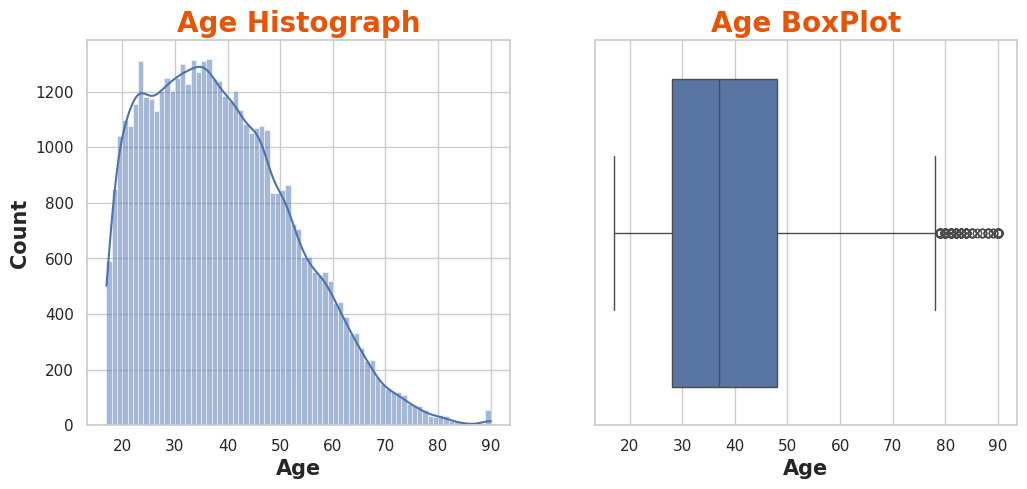

In [138]:
fig,axis=plt.subplots(nrows=1,ncols=2,figsize=(12,5))

sns.histplot(data=df,x="age",ax=axis[0],bins="rice",kde=True)
axis[0].set_title("Age Histograph",fontsize=20,color="#e85304",weight="bold")
axis[0].set_xlabel("Age",fontsize=15,weight="bold")
axis[0].set_ylabel("Count",fontsize=15,weight="bold")

sns.boxplot(data=df,x="age",ax=axis[1])
axis[1].set_title("Age BoxPlot",fontsize=20,color="#e85304",weight="bold")
axis[1].set_xlabel("Age",fontsize=15,weight="bold")
plt.show()

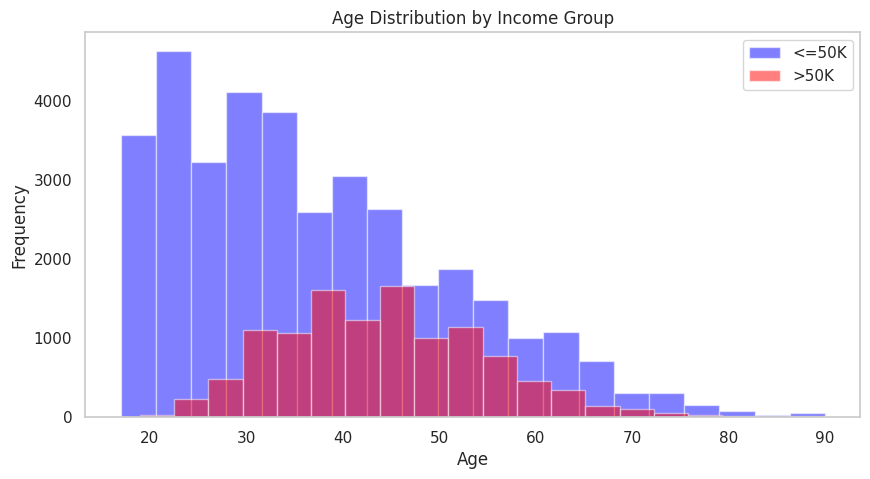

In [139]:
plt.figure(figsize=(10, 5))

plt.hist(df[df['income'] == '<=50K']['age'], bins=20, alpha=0.5, label='<=50K', color='blue')
plt.hist(df[df['income'] == '>50K']['age'], bins=20, alpha=0.5, label='>50K', color='red')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution by Income Group')
plt.legend()
plt.grid()

plt.show()

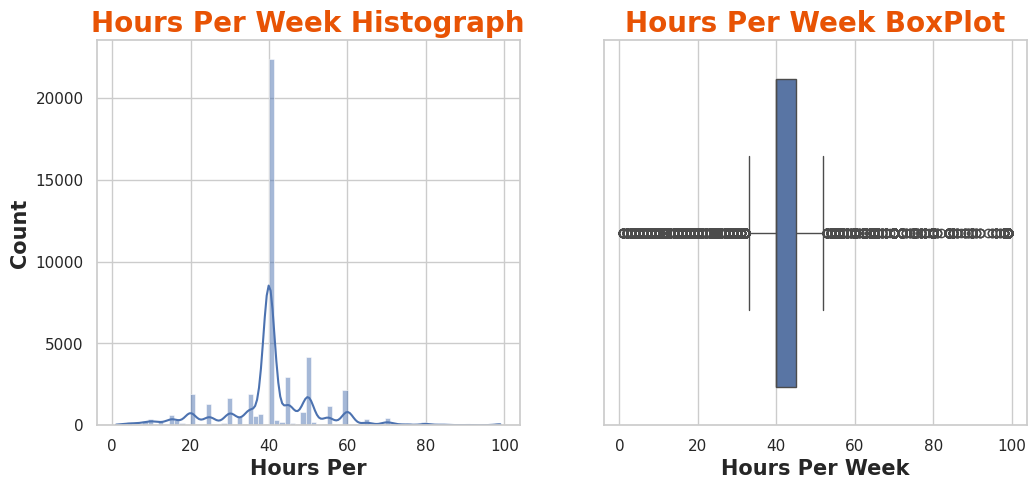

In [140]:
fig,axis=plt.subplots(nrows=1,ncols=2,figsize=(12,5))

sns.histplot(data=df,x="hours-per-week",ax=axis[0],bins="rice",kde=True)
axis[0].set_title("Hours Per Week Histograph",fontsize=20,color="#e85304",weight="bold")
axis[0].set_xlabel("Hours Per",fontsize=15,weight="bold")
axis[0].set_ylabel("Count",fontsize=15,weight="bold")

sns.boxplot(data=df,x="hours-per-week",ax=axis[1])
axis[1].set_title("Hours Per Week BoxPlot",fontsize=20,color="#e85304",weight="bold")
axis[1].set_xlabel("Hours Per Week",fontsize=15,weight="bold")
plt.show()

income
<=50K    34.0
>50K     43.0
Name: age, dtype: float64


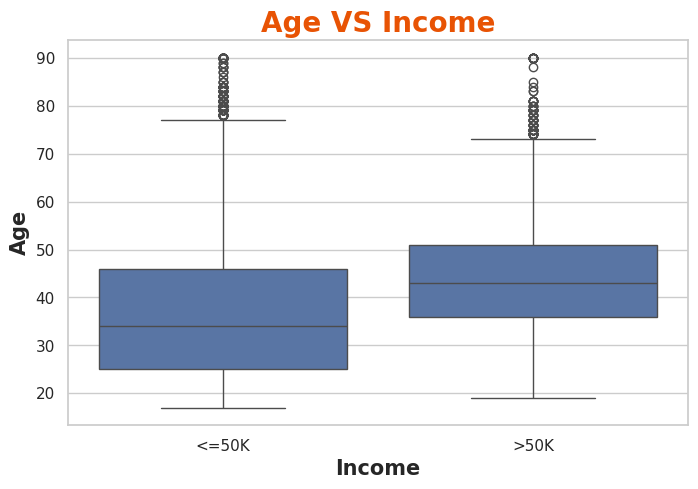

In [141]:
print(df.groupby("income").age.median())
plt.figure(figsize=(8,5))
plt.title("Age VS Income",weight='bold',fontsize=20,color='#e85304')
plt.xlabel("Income",weight='bold',fontsize=15)
plt.ylabel("Age",weight='bold',fontsize=15)
sns.boxplot(data=df,x="income",y="age")
plt.show()

In [143]:
def outliers_handler(real_data:pd.DataFrame(),col_name:str)->pd.DataFrame():
    data=real_data.copy()
    q1 = np.percentile(data[col_name],25)
    q3 = np.percentile(data[col_name],75)
    iqr = q3-q1
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)
    outliers = (data[col_name]>upper_bound) | (data[col_name]<lower_bound)
    num_of_outliers = len(data[outliers])
    if num_of_outliers <= len(data)*0.1:
        data = data[~outliers]
        print("Outliers dropped")
    else:
        data.loc[data[col_name]>upper_bound,col_name] = upper_bound
        data.loc[data[col_name]<lower_bound,col_name] = lower_bound
        print("Outliers replaced")
    return data

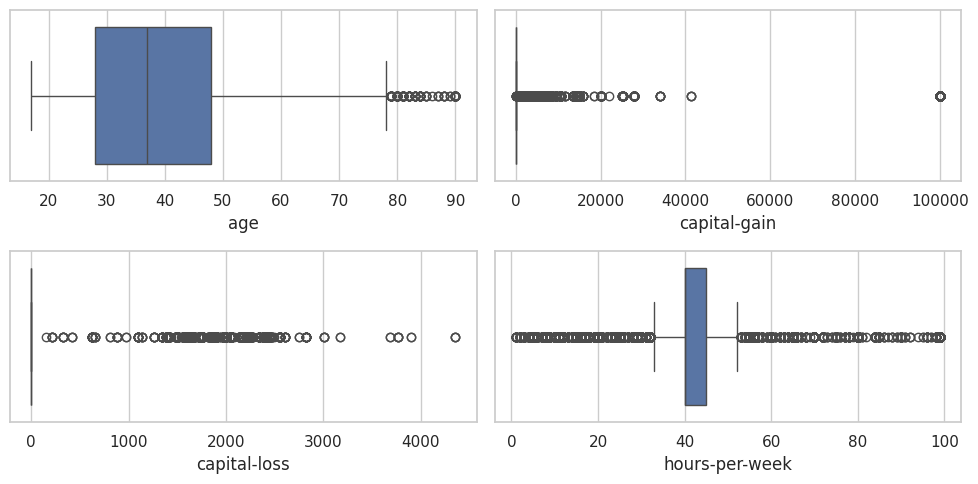

In [144]:
plt.figure(figsize=(10,5))
i=1
for col in df.select_dtypes(exclude="object").columns :
    if col in ["fnlwgt","educational-num"]:
        continue
    plt.subplot(2,2,i)
    sns.boxplot(data=df,x=col)
    i+=1
plt.tight_layout()
plt.show()

In [145]:
for i in ["age","hours-per-week"]:
    df=outliers_handler(df,i)

Outliers dropped
Outliers replaced


<ipython-input-143-871dc4ae488a>:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '52.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data[col_name]>upper_bound,col_name] = upper_bound


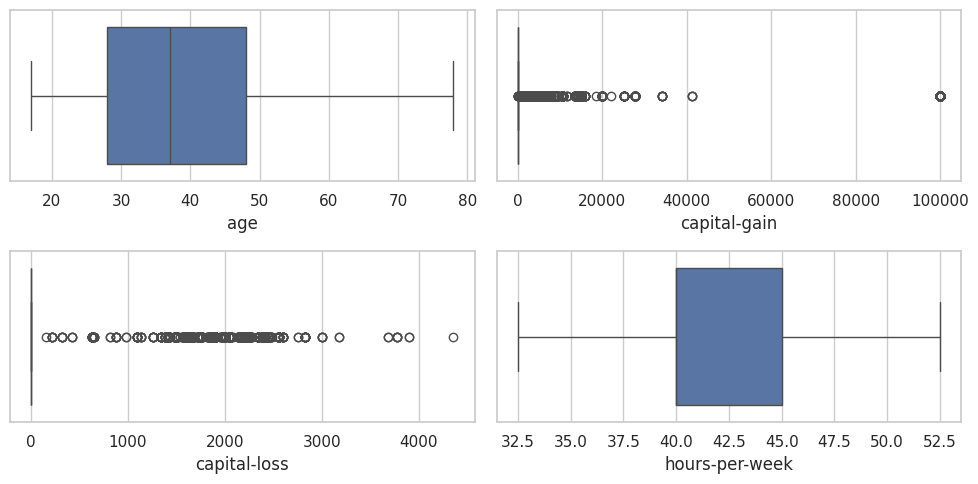

In [146]:
plt.figure(figsize=(10,5))
i=1
for col in df.select_dtypes(exclude="object").columns :
    if col in ["fnlwgt","educational-num"]:
        continue
    plt.subplot(2,2,i)
    sns.boxplot(data=df,x=col)
    i+=1
plt.tight_layout()
plt.show()

In [147]:
le =LabelEncoder()
for i in df.select_dtypes(include="object"):
    df[i]=le.fit_transform(df[i])

In [148]:
df.drop(["fnlwgt","native-country","occupation","workclass","race","education","gender"],axis=1,inplace=True)

In [149]:
X=df.drop(["income"],axis=1)
y=df.income

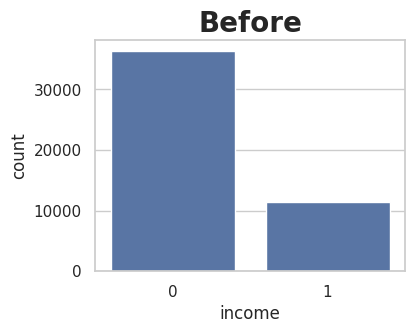

In [150]:
plt.figure(figsize=(4,3))
plt.title("Before",fontsize=20,weight="bold")
sns.countplot(x=y)
plt.show()

In [151]:
resampler = SMOTE()
X,y = resampler.fit_resample(X,y)

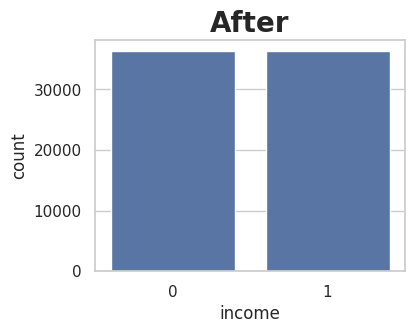

In [152]:
plt.figure(figsize=(4,3))
plt.title("After",fontsize=20,weight="bold")
sns.countplot(x=y)
plt.show()

In [153]:
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=42)

In [154]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train=pd.DataFrame(x_train,columns=X.columns.tolist())
x_test=pd.DataFrame(x_test,columns=X.columns.tolist())

# Logistic Regression
---

In [155]:
poly=PolynomialFeatures(degree=4)
x_train_poly=poly.fit_transform(x_train)
x_test_poly=poly.transform(x_test)

In [156]:
logsig_poly=LogisticRegression()
logsig_poly.fit(x_train_poly,y_train)
y_pred_poly=logsig_poly.predict(x_test_poly)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


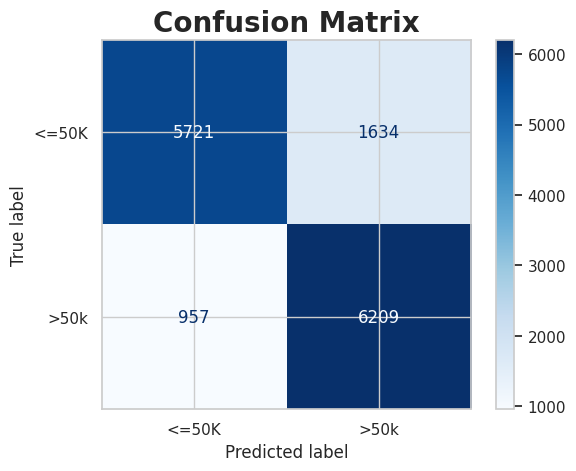

In [157]:
matrix=confusion_matrix(y_test,y_pred_poly)
figure=ConfusionMatrixDisplay(matrix,display_labels=["<=50K",">50k"])
figure.plot(cmap="Blues")
plt.title("Confusion Matrix",fontsize=20,weight="bold")
plt.show()

In [158]:
train_score_poly=logsig_poly.score(x_train_poly,y_train)
test_score_poly=logsig_poly.score(x_test_poly,y_test)
print(f"Train Score: {train_score_poly*100:.2f}\nTest Score: {test_score_poly*100:.2f}")
report=classification_report(y_test,y_pred_poly)
print(report)

Train Score: 82.21
Test Score: 82.16
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      7355
           1       0.79      0.87      0.83      7166

    accuracy                           0.82     14521
   macro avg       0.82      0.82      0.82     14521
weighted avg       0.82      0.82      0.82     14521



# K-Nearest Neighbors (KNN)
---

In [159]:
par={
    "n_neighbors":(1,30)
}
knn=KNeighborsClassifier()
k=KFold(n_splits=5,shuffle=True,random_state=41)
grid = GridSearchCV(knn,par,cv=k)
grid.fit(x_train,y_train)

print(f"Best Score: {grid.best_score_*100:.2f}\nBest Parameters: {grid.best_params_}")
grid.best_estimator_

Best Score: 81.99
Best Parameters: {'n_neighbors': 30}


KNeighborsClassifier(n_neighbors=30)

In [160]:
knn=KNeighborsClassifier(n_neighbors=grid.best_params_["n_neighbors"])
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=30)

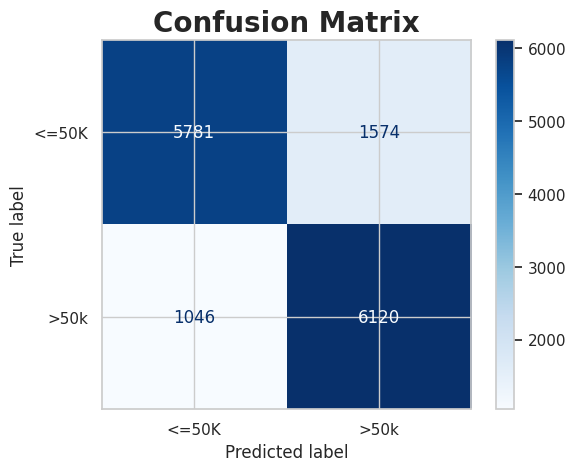

In [161]:
y_pred=knn.predict(x_test)
matrix=confusion_matrix(y_test,y_pred)
figure=ConfusionMatrixDisplay(matrix,display_labels=["<=50K",">50k"])
figure.plot(cmap="Blues")
plt.title("Confusion Matrix",fontsize=20,weight="bold")
plt.show()

In [162]:
train_score=knn.score(x_train,y_train)
test_score=knn.score(x_test,y_test)
print(f"Train Score: {train_score*100:.2f}\nTest Score: {test_score*100:.2f}")
report=classification_report(y_test,y_pred)
print(report)

Train Score: 83.06
Test Score: 81.96
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      7355
           1       0.80      0.85      0.82      7166

    accuracy                           0.82     14521
   macro avg       0.82      0.82      0.82     14521
weighted avg       0.82      0.82      0.82     14521



# Decision Tree
---

In [163]:
par={
    "max_depth":(3,12),
    "criterion":(0,1),
    "min_impurity_decrease":(0,0.001)
}

def evaluation_func(par):
    max_depth=int(par[0])
    criterion="gini" if int(par[1])==0 else "entropy"
    min_impurity_decrease=float(par[2])
    clf=DecisionTreeClassifier(criterion=criterion
                               ,max_depth=max_depth
                               ,min_impurity_decrease=min_impurity_decrease
                               ,random_state=41)
    clf.fit(x_train,y_train)
    return - clf.score(x_test,y_test)

np.random.seed(41)
res = differential_evolution(evaluation_func,
                             bounds=list(par.values()),
                             maxiter=15,
                             mutation=0.9,
                             recombination=0.8,
                             popsize=20)

print(f"Parameters: {res.x}\nScore: {-res.fun*100:.2f}")

Parameters: [1.10414280e+01 9.02007334e-01 1.10137108e-04]
Score: 83.43


In [164]:
criterion = "gini" if int(res.x[1])==0 else "entropy"
print(f"Criterion --> {criterion}\n\n")
dst = DecisionTreeClassifier(criterion=criterion,
                             max_depth=int(res.x[0]),
                             min_impurity_decrease=float(res.x[2])
                             ,random_state=41)
dst.fit(x_train,y_train)

Criterion --> gini




DecisionTreeClassifier(max_depth=11,
                       min_impurity_decrease=0.0001101371076587175,
                       random_state=41)

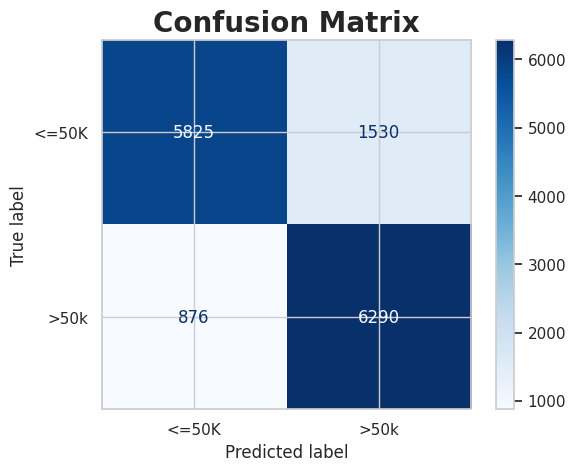

In [165]:
y_pred=dst.predict(x_test)
matrix=confusion_matrix(y_test,y_pred)
figure=ConfusionMatrixDisplay(matrix,display_labels=["<=50K",">50k"])
figure.plot(cmap="Blues")
plt.title("Confusion Matrix",fontsize=20,weight="bold")
plt.show()

In [166]:
train_score=dst.score(x_train,y_train)
test_score=dst.score(x_test,y_test)
print(f"Train Score: {train_score*100:.2f}\nTest Score: {test_score*100:.2f}")
report=classification_report(y_test,y_pred)
print(report)

Train Score: 83.77
Test Score: 83.43
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      7355
           1       0.80      0.88      0.84      7166

    accuracy                           0.83     14521
   macro avg       0.84      0.83      0.83     14521
weighted avg       0.84      0.83      0.83     14521



# Random Forest
---

In [167]:
par={
    "max_depth": (2, 20),
    "n_estimators" : (100,300)
}

def evaluation_func(par):
    max_depth = int(par[0])
    n_estimators=int(par[1])
    clf= RandomForestClassifier(max_depth=max_depth,
                              n_estimators=n_estimators,
                              random_state=41)
    clf.fit(x_train,y_train)
    return - clf.score(x_test,y_test) # want to max


np.random.seed(41)
result = differential_evolution(
    evaluation_func,
    bounds=list(par.values()),
    maxiter=15,
    popsize=5,
    mutation=0.9,
    recombination=0.8,
)
print(f"Parameters: {result.x}\nScore: {-result.fun*100:.2f}")

Parameters: [ 19.54150824 226.34220941]
Score: 85.74


In [168]:
rfc = RandomForestClassifier(max_depth=int(result.x[0]),
                              n_estimators=int(result.x[1]),
                              random_state=41)
rfc.fit(x_train,y_train)

RandomForestClassifier(max_depth=19, n_estimators=226, random_state=41)

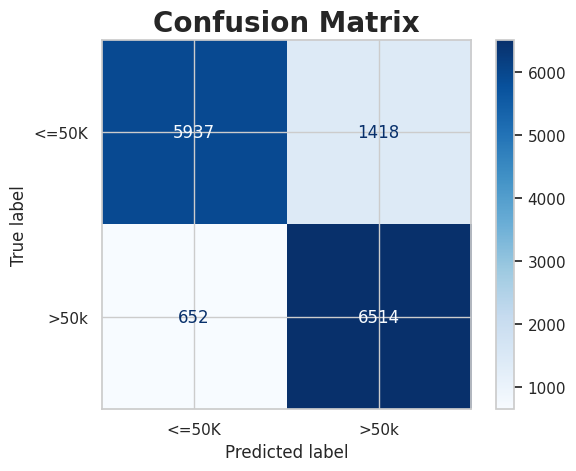

In [169]:
y_pred=rfc.predict(x_test)
matrix=confusion_matrix(y_test,y_pred)
figure=ConfusionMatrixDisplay(matrix,display_labels=["<=50K",">50k"])
figure.plot(cmap="Blues")
plt.title("Confusion Matrix",fontsize=20,weight="bold")
plt.show()

In [170]:
train_score=rfc.score(x_train,y_train)
test_score=rfc.score(x_test,y_test)
print(f"Train Score: {train_score*100:.2f}\nTest Score: {test_score*100:.2f}")
report=classification_report(y_test,y_pred)
print(report)

Train Score: 88.10
Test Score: 85.74
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      7355
           1       0.82      0.91      0.86      7166

    accuracy                           0.86     14521
   macro avg       0.86      0.86      0.86     14521
weighted avg       0.86      0.86      0.86     14521

